# Workspace \#9: ``model.py``

In [1]:
# %load firstcell.py
# autoreloading for imported modules
%load_ext autoreload
%autoreload 2

# getting future division
from __future__ import division

# numpy
import numpy as np
from numpy import pi, sqrt, log, log10, power, exp

#scipy
from scipy.interpolate import interp1d

# matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import rc
from matplotlib.lines import Line2D

# other
import os
from tqdm import tqdm

# matplotlib style
%matplotlib inline

%config InlineBackend.figure_format = "retina"
rcParams['figure.figsize'] = (13, 8)
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['New Times Roman']
rc('text', usetex=True)

# current directory
current_dir = os.getcwd()

In [2]:
from random import random

import sys
sys.path.insert(0, '../')

import tools as tl
import constants as ct
import particle as pt
import ska as sk
import astro as ap
import echo as ec
import routines as rt
import data as dt
import model as md

../ska.py:29: RuntimeWarning: divide by zero encountered in true_divide
  B_eff = 2.*r / np.sqrt(number_of_tel)
/home/buenabad/anaconda2/lib/python2.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/home/buenabad/anaconda2/lib/python2.7/site-packages/healpy/fitsfunc.py:403: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


NSIDE = 512
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


In [3]:
# The contents of model.py
dir(md)

['__builtins__',
 '__doc__',
 '__file__',
 '__name__',
 '__package__',
 'ap',
 'ct',
 'ec',
 'np',
 'pt',
 'rt',
 'sk',
 'snr_routine']

In [4]:
# defining a test SNR
test_snr = dt.SuperNovaRemnant()
# test_snr.__dict__ = {
#     'age': 35000.,
#     'alpha': 0.7,
#     'gamma': 1.8,
#     'ang_size': 84.8528137423857,
#     'sr': 0.0004784858509023251,
#     'distance': 1.8,
#     'no_dist': False,
#     'l': 39.7,
#     'b': -2.,
#     'name': 'W50',
#     'snu_at_1GHz': 310.0,
#     'no_flux': False,
#     'type': 'S'}

test_snr.__dict__ = {
    'age': 36000.,
    'alpha': 0.7,
#     'alpha': 0.5,
    'gamma': ap.gamma_from_alpha(0.7),
    'ang_size': 48.0,
    'sr': 0.00015311679381005744,
    'distance': 1.9,
    'no_dist': False,
    'l': 6.4,
    'b': -0.1,
    'name': 'W28/G6.4-0.1',
    'snu_at_1GHz': 310.0,
    'no_flux': False,
    'type': 'S'}

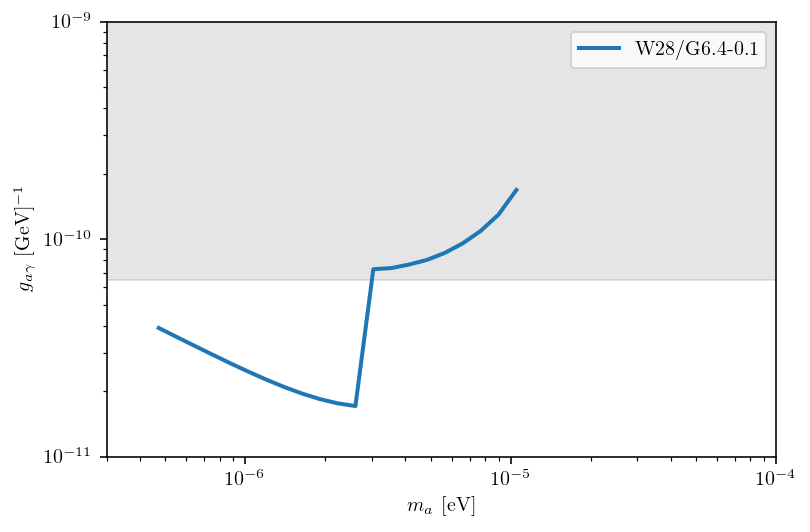

In [7]:
# t_extra_old = 5.e4
# t_extra_arr = [0., 2000., 1.e4]
t_extra_arr = [0.]
# t_age = None #set in snr.__dict__
t_trans_over_t_peak = 1.
ma_arr = np.logspace(np.log10(1e-7), np.log10(2e-4), 50)
sig_noi_thres = 1.
ga_ref = 1.e-10 # doesn't matter, will be rescaled

counter = 0
# best_snr = None
# best_ga = 1.# at first ma point

plt.subplots()
#for _, snr in tqdm(snrs_dct.items(), total=len(snrs_dct.keys())):

for idx, t_extra_old in enumerate(t_extra_arr):
    color = 'C'+str(idx)
    for snr in [test_snr]:
        
        try:
            distance = snr.get_distance()

        except:
            continue
        
#         L_peak = snr.Lpk
#         t_peak = snr.tpk
        
        tage = snr.age
        snu_echo_kwargs = {'tmin_default':None,
                           'Nt':100000, # for a fine enough array
                           'xmin':ct._au_over_kpc_,
                           'xmax_default':100.,
                           'use_quad':False,
                           'lin_space':False,
                           'Nint':100000, # for a fine enough array
                           't_extra_old':t_extra_old
                          }
        # data:
        data = {'deltaE_over_E':1.e-3,
                'f_Delta':0.721,
                'exp':'SKA',
                'total_observing_time':100.,
                'verbose':0,
                'correlation_mode':'interferometry',
                'average':True
               }
        
        t_trans = 100.
        t_peak = t_trans*365.
        
        lightcurve_params = {'t_peak':t_peak,
#                              'L_peak':L_peak,
                             't_age':tage,
                             't_trans':t_trans,
                             'L_today':snr.get_luminosity()
                            }
        
        sig_noi = md.snr_routine(ma_arr, ga_ref,
                                 snr,
                                 lightcurve_params=lightcurve_params,
                                 snu_echo_kwargs=snu_echo_kwargs,
                                 data=data,
                                 output_all=False)
        
        ga_arr = ec.ga_reach(sig_noi_thres, sig_noi, ga_ref)
        
        plt.plot(ma_arr, ga_arr, lw='2.', color=color, alpha=1., label=snr.name)
        counter += 1

#         if best_ga > ga_arr[0]:
#             best_snr = snr
#             best_ga = ga_arr[0]
    #     if counter == 2:
    #         break

ga_cast = 6.5e-11
plt.fill_between([1e-7, 1e-2], ga_cast, 1, color='grey', alpha=0.2)

plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-11, 1e-9)
plt.xlim(3e-7, 1e-4)
plt.xlabel('$m_a$ [eV]')
plt.ylabel('$g_{a\gamma}$ [GeV]$^{-1}$')
plt.legend(loc='best')


# title_str = r"SNR: D={D:.3f} kpc, Lpk=10$^{{{log10Lpk:.1f}}}$, tpk=10$^{{{log10tpk:.1f}}}$,\\$\ell$={ell:.1f},$b$={b:.1f}, $\alpha$={alpha:.1f}, S/N={sn:.0f}"
# title = title_str.format(D=snr.distance,
#                          log10Lpk=np.log10(snr.Lpk), 
#                          log10tpk=np.log10(snr.tpk),
#                          ell=snr.l,
#                          b=snr.b,
#                          alpha=snr.alpha,
#                          sn=sig_noi_thres)

# plt.title(title)

# print('ga_arr:',  ga_arr)

### Studying Green's Catalogue

In [9]:
verbose = 2
snr_results = {}

ga_ref = 1.e-10

tpk = 10.**(1.7)
Lpk = 10.**(28.)
t_trans_over_t_peak = 30.
t_trans = (tpk/365.)*t_trans_over_t_peak

for name, snr in dt.snrs_cut.items():
    
    lightcurve_params = {'t_peak':tpk,
                         'L_peak':Lpk,
                         't_trans':t_trans}
    
    snu_echo_kwargs = {'tmin_default':None,
                       'Nt':int(30001),
                       'xmin':ct._au_over_kpc_,
                       'xmax_default':100.,
                       'use_quad':False,
                       'lin_space':False,
                       'Nint':int(30001),
                       't_extra_old':0.
                      }
    # data:
    data = {'deltaE_over_E':1.e-3,
            'f_Delta':0.721,
            'exper':'SKA',
            'total_observing_time':100.,
            'verbose':0,
            'correlation_mode':'interferometry',
            'average':True
           }
    
    z, new_output = md.snr_routine(pt.ma_from_nu(1.), ga_ref,
                                   snr,
                                   lightcurve_params=lightcurve_params,
                                   snu_echo_kwargs=snu_echo_kwargs,
                                   data=data,
                                   output_all=True,
                                   verbose=verbose)
    
    snr_results[name] = new_output
    
    # obtaining L_today
    L0 = snr.get_luminosity() # [cgs]
    # computing t_age [years]
    print(ap.tage_compute(Lpk,
                          tpk,
                          t_trans,
                          L0,
                          ap.gamma_from_alpha(snr.alpha)))

SNR size=3.2e-06. Value will be respected.
signal power:2.00550423981e-21
noise power:1.14275858175e-17
s/n: 0.000175496755993

201.24038422609357
SNR size=3.3e-07. Value will be respected.
signal power:1.27014126236e-21
noise power:1.34222828648e-17
s/n: 9.46293022699e-05

64.69820769988003
SNR size=1.1e-06. Value will be respected.
signal power:8.62771314803e-21
noise power:1.32491143539e-17
s/n: 0.000651191688561

202.5714684907498
SNR size=6.4e-06. Value will be respected.
signal power:2.87162802078e-21
noise power:1.24185976141e-17
s/n: 0.000231236095251

264.83602763931225
SNR size=2.7e-05. Value will be respected.
signal power:1.14044161856e-21
noise power:8.23781308463e-18
s/n: 0.000138439851311

168.36045887067888
SNR size=4.1e-04. Value will be respected.


../echo.py:1244: RuntimeWarning: invalid value encountered in double_scalars
  res = signal_power / noise_power
../routines.py:336: RuntimeWarning: invalid value encountered in double_scalars
  new_output['S/N'] = new_output['signal_power'] / new_output['noise_power']


signal power:0.0
noise power:0.0
s/n: nan

104.46782331277248
SNR size=1.9e-05. Value will be respected.
signal power:7.08308067063e-22
noise power:9.11910332065e-18
s/n: 7.76729950476e-05

97.34612327216263
SNR size=4.3e-06. Value will be respected.
signal power:2.6343926006e-21
noise power:1.04839017418e-17
s/n: 0.000251279787381

337.2560003630851
SNR size=6.1e-05. Value will be respected.
signal power:4.55837193361e-21
noise power:5.96191141003e-18
s/n: 0.000764582299217

670.7018688892803
SNR size=1.1e-04. Value will be respected.
signal power:5.4385726721e-22
noise power:4.99028240965e-18
s/n: 0.000108983264386

104.95535659444904
SNR size=7.2e-05. Value will be respected.
signal power:1.05563527984e-20
noise power:5.67551224392e-18
s/n: 0.00185998238479

798.5739332017274
SNR size=3.2e-06. Value will be respected.
signal power:1.81219923357e-21
noise power:1.0910062375e-17
s/n: 0.00016610347139

185.40234248434967
SNR size=7.2e-04. Value will be respected.
signal power:0.0
noise